In [31]:
import threading
import heapq
from math import inf
from utils_discrete import GraphConstructionDiscretization, extract_costs, check_pareto_optimality, plot_costs, reconstruct_solution_paths
import time
import numpy as np
import networkx as nx
from placeholder import *

In [32]:
# =============================================================================
# Constants, UAV parameters, and initial conditions
# =============================================================================
# Define QZ circles as tuples (x, y, radius, only_electric_radius, risk_limit, toggle_only_electric_or_no_path) toggle_only_electric_or_no_path = 0 for no path, 1 for only electric

# Map with two QZ circles
map_qz = [(0.0, 0.0, 6.0, 2.0, 30, 1), (12.0, 10.0, 4.0, 1.5, 30, 1)]
max_risk_limit = 200 #2 / 3 * sum([circle[-2] for circle in map_qz]) ### Total risk limit i.e. limit on the sum of all the risk limits
acceptable_risk_limit = 0 ### 1 / 3 * sum([circle[-2] for circle in map_qz])
start = (-5, -5)       # Starting point
goal = (15, 15)        # Goal point

# UAV characteristics
alpha = 10                      ### Discharge rate 
recharge_factor = 2             ### Factor by which recharge rate less than discharge rate
beta = alpha / recharge_factor  ### Recharge rate

q_min, q_max, q_act = 20, 100, 70 ### Minimum SOC limit, maximum SOC limit, and SOC at the state
discretization_angle = 3         ### Discretization angle for QZ in degrees

In [33]:
# =============================================================================
# Graph Construction and Node Creation
# =============================================================================
# Instantiate the graph construction object.
graph_object = GraphConstructionDiscretization(map_qz, start, goal, q_min, q_max, q_act, alpha, beta, discretization_angle)

start_time = time.time()

# Create nodes ( x_pos, y_pos, qz_index, SOC) for the graph 
# Create the index maps and reverse index maps mapping nodes to node index. 
nodes, index_map, reverse_index_map = graph_object.create_nodes()

# Build the visibility graph
graph_object.build_visibility_graph(reverse_index_map)
end_time = time.time()

## Assign heuristic cost to each node
graph_object.assign_heuristic_costs(reverse_index_map)

print(f"The time req for graph construction: {end_time-start_time}")

The time req for graph construction: 6.061440944671631


In [34]:
def update_global_upper_bound(key, upper_bounds, new_value):
    # Thread-safe update of an upper bound.
    with ub_lock:
        if new_value < upper_bounds[key]:
            upper_bounds[key] = new_value

def update_upper_bound(graph_object, state, upper_bound, Type="forward", Cost_type="fuel_cost"):
    # Thread-safe update of an upper bound.
    with ub_lock:
        graph_object.visibility_graph.nodes[state]["upper_bound_cost"][Type][Cost_type] = upper_bound

def update_heuristic(graph_object, state, heuristic, Type="backward", Cost_type="fuel_cost"):
    # Thread-safe update of an upper bound.
    with ub_lock:
        graph_object.visibility_graph.nodes[state]["heuristic_cost"][Type][Cost_type] = heuristic

upper_bounds_global = {"ub1forward": np.inf, "ub2forward": np.inf, "ub1backward": np.inf, "ub2backward": np.inf}
ub_lock = threading.Lock()

In [36]:
### Cost_Bounded_forward_Astar
### Cost_type = 1 for fuel cost, 2 for risk cost
def Cost_Bounded_forward_Astar_f1f2(graph_object, start_state, goal_state, upper_bounds_global): 
    # Initialize the priority queue with the start state.
    open_list = []
    closed = []
    f1min = {node: np.inf for node in graph_object.visibility_graph.nodes()}    
    ### node is of the form (f1, g1, f2, g2, state)
    heapq.heappush(open_list, (0, 0, 0, 0, start_state))
    
    while open_list:
        current_f1, current_g1, current_f2, current_g2, current_state = heapq.heappop(open_list)
        
        if current_state not in closed:
            ### Check if the current state is the goal state
            if current_state == goal_state:
                update_global_upper_bound("ub2forward", upper_bounds_global, current_g2)
                update_heuristic(graph_object, current_state, current_g1, Type="backward", Cost_type="fuel_cost")
                f1min[current_state] = current_g1
                closed.append(current_state)
                print(f"The ub2forward is updated to {upper_bounds_global['ub2forward']}, and goal_g1 is {current_g1}")
                print(f"fuel cost to goal: {current_g1}, risk cost to goal: {current_g2}")
                continue
            
            ### Check whether the current state exceeds the global upper bound
            with ub_lock:
                ub_g1_forward = upper_bounds_global["ub1forward"]
                ub_g2_forward = upper_bounds_global["ub2forward"]
            
            # if current_g1 > ub_g1_forward or current_g2 > ub_g2_forward:
            #     ### Bascially path from this node is not feasible
            #     update_heuristic(graph_object, current_state, np.inf, Type="backward", Cost_type="fuel_cost")
            #     closed.append(current_state)
            #     continue
            
            ### Update the heuristic
            update_heuristic(graph_object, current_state, current_g1, Type="backward", Cost_type="fuel_cost")
            ### As this a new state not in closed list, this is the min cost1 for this state, thus we can upper bound the cost2 for this state 
            update_upper_bound(graph_object, current_state, current_g2, Type="forward", Cost_type="risk_cost")
            
            ### Expand successors
            for successor in graph_object.visibility_graph.successors(current_state):
                if successor not in closed:
                    with ub_lock:
                        edge_data = graph_object.visibility_graph.edges[current_state, successor]
                        node_data = graph_object.visibility_graph.nodes[successor]
                    
                    successor_g1 = current_g1 + edge_data["fuel_cost"]
                    successor_g2 = current_g2 + edge_data["risk_cost"]
                    
                    successor_f1 = successor_g1 + node_data["heuristic_cost"]["forward"]["fuel_cost"]
                    successor_f2 = successor_g2 + node_data["heuristic_cost"]["forward"]["risk_cost"]
                    
                    ### If the f1 and f2 values of the successor exceed the global upper bound, skip it
                    # if successor_f1 > ub_g1_forward or successor_f2 > ub_g2_forward:
                    #     update_heuristic(graph_object, successor, np.inf, Type="backward", Cost_type="fuel_cost")
                    #     continue
                    #
                    ### The successor is in open list, but its value less than the current g1 value, update the g1min value and put it in the open list
                    if successor_f1 < f1min[successor]:
                        f1min[successor] = successor_f1
                        heapq.heappush(open_list, (successor_f1, successor_g1, successor_f2, successor_g2, successor))
                    
            closed.append(current_state)

### Cost_Bounded_forward_Astar
### Cost_type = 1 for fuel cost, 2 for risk cost
def Cost_Bounded_backward_Astar_f2f1(graph_object, start_state, goal_state, upper_bounds_global): 
    # Initialize the priority queue with the start state.
    open_list = []
    closed = []
    f2min = {node: np.inf for node in graph_object.visibility_graph.nodes()}    
    ### node is of the form (f1, g1, f2, g2, state)
    heapq.heappush(open_list, (0, 0, 0, 0, goal_state))
    
    while open_list:
        current_f2, current_g2, current_f1, current_g1, current_state = heapq.heappop(open_list)
        
        if current_state not in closed:
            ### Check if the current state is the goal state
            if current_state == start_state:
                update_global_upper_bound("ub1backward", upper_bounds_global, current_g1)
                update_heuristic(graph_object, current_state, current_g2, Type="forward", Cost_type="risk_cost")
                f2min[current_state] = current_g2
                closed.append(current_state)
                print(f"The ub1backward is updated to {upper_bounds_global['ub1backward']}, and goal_g2 is {current_g2}")
                continue
            
            with ub_lock:
                ub_f1_backward = upper_bounds_global["ub1backward"]
                ub_f2_backward = upper_bounds_global["ub2backward"]
            
            ### Check whether the current state exceeds the global upper bound
            # if current_f1 > ub_f1_backward or current_f2 > ub_f2_backward:
            #     ### Bascially path from this node is not feasible
            #     update_heuristic(graph_object, current_state, np.inf, Type="forward", Cost_type="risk_cost")
            #     closed.append(current_state)
            #     continue
            
            update_heuristic(graph_object, current_state, current_g2, Type="forward", Cost_type="risk_cost")
            ### As this a new state not in closed list, this is the min cost2 for this state, thus we can upper bound the cost1 for this state 
            update_upper_bound(graph_object, current_state, current_g1, Type="backward", Cost_type="fuel_cost")
            
            # ### Check whether the current state exceeds the local upper bound
            # if current_g1 > graph_object.visibility_graph[current_state]["upper_bound"]["forward"] or current_g2 > graph_object.visibility_graph[current_state]["upper_bound"]["forward"]:
            #     ### Path possible from this this node, but the current path won't be parato optimal
            #     continue
            
            ### Expand successors
            for successor in graph_object.visibility_graph.successors(current_state):
                if successor not in closed:
                    with ub_lock:
                        edge_data = graph_object.visibility_graph.edges[current_state, successor]
                        node_data = graph_object.visibility_graph.nodes[successor]
                    
                    successor_g1 = current_g1 + edge_data["fuel_cost"]
                    successor_g2 = current_g2 + edge_data["risk_cost"]
                    
                    successor_f1 = successor_g1 + node_data["heuristic_cost"]["backward"]["fuel_cost"]
                    successor_f2 = successor_g2 + node_data["heuristic_cost"]["backward"]["risk_cost"]
                    
                    ### If the f1 and f2 values of the successor exceed the global upper bound, skip it
                    # if successor_f1 > ub_f1_backward or successor_f2 > ub_f2_backward:
                    #     update_heuristic(graph_object, successor, np.inf, Type="forward", Cost_type="risk_cost")
                    #     continue
                    
                    ### The successor is in open list, but its value less than the current g1 value, update the g1min value and put it in the open list
                    if successor_f2 < f2min[successor]:
                        f2min[successor] = successor_f2
                        heapq.heappush(open_list, ( successor_f2, successor_g2, successor_f1, successor_g1, successor))
                    
            closed.append(current_state)

## Cost_Bounded_forward_Astar
## Cost_type = 1 for fuel cost, 2 for risk cost
def Cost_Bounded_forward_Astar_f2f1(graph_object, start_state, goal_state, upper_bounds_global): 
    # Initialize the priority queue with the start state.
    open_list = []
    closed = []
    f2min = {node: np.inf for node in graph_object.visibility_graph.nodes()}    
    ### node is of the form (f2, g2, f1, g1, state)
    heapq.heappush(open_list, (0, 0, 0, 0, start_state))
    
    while open_list:
        current_f2, current_g2, current_f1, current_g1, current_state = heapq.heappop(open_list)
        
        if current_state not in closed:
            ### Check if the current state is the goal state
            if current_state == goal_state:
                update_global_upper_bound("ub1forward", upper_bounds_global, current_g1)
                print(f"The current g1 is {current_g1} and current g2 is {current_g2}")
                update_heuristic(graph_object, current_state, current_g2, Type="backward", Cost_type="risk_cost")
                f2min[current_state] = current_g2
                closed.append(current_state) 
                continue
            
            ### Check whether the current state exceeds the global upper bound
            with ub_lock:
                ub_g1_forward = upper_bounds_global["ub1forward"]
                ub_g2_forward = upper_bounds_global["ub2forward"]
            
            # if current_g1 > ub_g1_forward or current_g2 > ub_g2_forward:
            #     ### Bascially path from this node is not feasible
            #     update_heuristic(graph_object, current_state, np.inf, Type="backward", Cost_type="risk_cost")
            #     closed.append(current_state)
            #     continue
            
            update_heuristic(graph_object, current_state, current_g2, Type="backward", Cost_type="risk_cost")
            ### As this a new state not in closed list, this is the min cost2 for this state, thus we can upper bound the cost1 for this state 
            update_upper_bound(graph_object, current_state, current_g1, Type="forward", Cost_type="fuel_cost")
            
            # ### Check whether the current state exceeds the local upper bound
            # if current_g1 > graph_object.visibility_graph[current_state]["upper_bound"]["forward"] or current_g2 > graph_object.visibility_graph[current_state]["upper_bound"]["forward"]:
            #     ### Path possible from this this node, but the current path won't be parato optimal
            #     continue
            
            ### Expand successors
            for successor in graph_object.visibility_graph.successors(current_state):
                if successor not in closed:
                    with ub_lock:
                        edge_data = graph_object.visibility_graph.edges[current_state, successor]
                        node_data = graph_object.visibility_graph.nodes[successor]
                    
                    successor_g1 = current_g1 + edge_data["fuel_cost"]
                    successor_g2 = current_g2 + edge_data["risk_cost"]
                    
                    successor_f1 = successor_g1 + node_data["heuristic_cost"]["forward"]["fuel_cost"]
                    successor_f2 = successor_g2 + node_data["heuristic_cost"]["forward"]["risk_cost"]
                    
                    ### If the f1 and f2 values of the successor exceed the global upper bound, skip it
                    # if successor_f2 > ub_g2_forward or successor_f2 > ub_g2_forward:
                    #     update_heuristic(graph_object, successor, np.inf, Type="backward", Cost_type="risk_cost")
                    #     continue
                    
                    ### The successor is in open list, but its value less than the current g1 value, update the g1min value and put it in the open list
                    if successor_f2 < f2min[successor]:
                        f2min[successor] = successor_f2
                        heapq.heappush(open_list, (successor_f2, successor_g2, successor_f1, successor_g1, successor))

            closed.append(current_state)

## Cost_Bounded_forward_Astar
## Cost_type = 1 for fuel cost, 2 for risk cost

def Cost_Bounded_backward_Astar_f1f2(graph_object, start_state, goal_state, upper_bounds_global): 
    # Initialize the priority queue with the start state.
    open_list = []
    closed = []
    f1min = {node: np.inf for node in graph_object.visibility_graph.nodes()}    
    ### node is of the form (f1, g1, f2, g2, state)
    heapq.heappush(open_list, (0, 0, 0, 0, goal_state))
    
    while open_list:
        current_f1, current_g1, current_f2, current_g2, current_state = heapq.heappop(open_list)
        
        if current_state not in closed:
            ### Check if the current state is the goal state
            if current_state == start_state:
                update_global_upper_bound("ub2backward", upper_bounds_global, current_g2)
                update_heuristic(graph_object, current_state, current_g1, Type="forward", Cost_type="fuel_cost")
                print(f"The current g1 is {current_g1} and current g2 is {current_g2}")
                f1min[current_state] = current_g1
                closed.append(current_state) 
                continue
            
            with ub_lock:
                ub_f1_backward = upper_bounds_global["ub1backward"]
                ub_f2_backward = upper_bounds_global["ub2backward"]
            
            ### Check whether the current state exceeds the global upper bound
            # if current_g1 > ub_f1_backward or current_g2 > ub_f2_backward:
            #     ### Bascially path from this node is not feasible
            #     update_heuristic(graph_object, current_state, np.inf, Type="forward", Cost_type="fuel_cost")
            #     closed.append(current_state)
            #     continue
            
            update_heuristic(graph_object, current_state, current_g1, Type="forward", Cost_type="fuel_cost")
            ### As this a new state not in closed list, this is the min cost2 for this state, thus we can upper bound the cost1 for this state 
            update_upper_bound(graph_object, current_state, current_g2, Type="backward", Cost_type="risk_cost")
            
            ### Expand successors
            for successor in graph_object.visibility_graph.successors(current_state):
                if successor not in closed:
                    with ub_lock:
                        edge_data = graph_object.visibility_graph.edges[current_state, successor]
                        node_data = graph_object.visibility_graph.nodes[successor]
                    
                    successor_g1 = current_g1 + edge_data["fuel_cost"]
                    successor_g2 = current_g2 + edge_data["risk_cost"]
                    
                    successor_f1 = successor_g1 + node_data["heuristic_cost"]["backward"]["fuel_cost"]
                    successor_f2 = successor_g2 + node_data["heuristic_cost"]["backward"]["risk_cost"]
                    
                    ### If the f1 and f2 values of the successor exceed the global upper bound, skip it
                    # if successor_f1 > ub_f1_backward or successor_f2 > ub_f2_backward:
                    #     update_heuristic(graph_object, successor, np.inf, Type="forward", Cost_type="fuel_cost")
                    #     continue
                    
                    ### The successor is in open list, but its value less than the current g1 value, update the g1min value and put it in the open list
                    if successor_f1 < f1min[successor]:
                        f1min[successor] = successor_f1
                        heapq.heappush(open_list, ( successor_f1, successor_g1, successor_f2, successor_g2, successor))
                    
            closed.append(current_state)

In [37]:
### parallel code:
def run_parallel_cost_bounded_astar(graph_object, start_state, goal_state, upper_bounds_global, type = "first"):
    results = {}

    def forward_worker():
        if type == "first":
            Cost_Bounded_forward_Astar_f1f2(graph_object, start_state, goal_state, upper_bounds_global)
        else:
            Cost_Bounded_forward_Astar_f2f1(graph_object, start_state, goal_state, upper_bounds_global)
    def backward_worker():
        # Note: for the backward search, we call start=goal and goal=start,
        # because we run on the reversed graph.
        if type == "first":
            Cost_Bounded_backward_Astar_f2f1(graph_object, start_state, goal_state, upper_bounds_global)
        else:
            Cost_Bounded_backward_Astar_f1f2(graph_object, start_state, goal_state, upper_bounds_global)
    
    t1 = threading.Thread(target=forward_worker)
    t2 = threading.Thread(target=backward_worker)
    t1.start()
    t2.start()
    t1.join()
    t2.join()

start_time = time.time()
run_parallel_cost_bounded_astar(graph_object, "s", "g", upper_bounds_global, type="second")
end_time = time.time()
print(f"The time req for second heuristic: {end_time-start_time}")

start_time = time.time()
run_parallel_cost_bounded_astar(graph_object, "s", "g", upper_bounds_global, type="first")
end_time = time.time()
print(f"The time req for first heuristic: {end_time-start_time}")

The current g1 is 19.394165830050433 and current g2 is 65.5354731446998
The current g1 is 51.246791027014524 and current g2 is 5.47862356024305
The time req for second heuristic: 2.0804455280303955
The ub2forward is updated to 65.5354731446998, and goal_g1 is 19.394165830050433
fuel cost to goal: 19.394165830050433, risk cost to goal: 65.5354731446998
The ub1backward is updated to 51.24679102701456, and goal_g2 is 5.47862356024305
The time req for first heuristic: 0.809725284576416


In [38]:

# all_states = list(graph_object.visibility_graph.nodes)

# g1_min = {state: np.inf for state in all_states}
# g2_min = {state: np.inf for state in all_states}

# g1_min["s"] = upper_bounds_global["ub1backward"]
# g2_min["g"] = upper_bounds_global["ub2forward"]

# def update_g_min(g1_min, g2_min, current_state, current_g, type=1):
#     with ub_lock:
#         if type == 1:
#             older = g1_min[current_state]
#             g1_min[current_state] = current_g
#             if current_state == "s":
#                 print(f"Updated g1_min for {current_state} from {older} to {g1_min[current_state]}")
#         else:
#             older = g2_min[current_state]
#             g2_min[current_state] = current_g
#             if current_state == "g":
#                 print(f"Updated g2_min for {current_state} from {older} to {g2_min[current_state]}")

# def biobjective_search_forward( graph_object, start_state="s", goal_state="g", reduce_factor=1):
#     """
#     Performs a biobjective search (fuel cost and risk cost) over the visibility graph.
    
#     Args:
#         graph_object: The graph object containing the visibility graph, and other relevant information.
#         start_state: Identifier for the start node (default "s").
#         goal_state: Identifier for the goal node (default "g").
#         reduce_factor: A factor used in pruning dominated paths.
        
#     Returns:
#         sols: A dict mapping each state to a list of solution tuples.
#         g2_min: A dict mapping each state to its minimum risk cost.
#     """
#     max_risk_limit, acceptable_risk_limit = graph_object.max_risk_limit, graph_object.acceptable_risk_limit

#     # print("All states:", all_states)
#     open_set = []
#     sols = {state: [] for state in all_states}

#     # The start node is represented as a tuple: (f1, f2, g1, g2, state)
#     # and its parent is set to None.
#     start_node = (0, 0, 0, 0, start_state)
#     heapq.heappush(open_set, [start_node, (None, None, None, None, None)])

#     while open_set:
#         current_node, parent_node = heapq.heappop(open_set)
#         current_f1, current_f2, current_g1, current_g2, current_state = current_node
#         # print(f"current_state: {current_state}, current_f1: {current_f1}, current_f2: {current_f2}, current_g1: {current_g1}, current_g2: {current_g2}")  
#         ### Check the global upper bound
#         with ub_lock:
#             if current_f1 > g1_min["s"]:
#                 # print("global upper bound reached for g1")
#                 break
        
#             # Prune if the current risk cost is dominated
#             if (current_g2 >= reduce_factor*g2_min[current_state] or
#                 current_f2 >= reduce_factor*g2_min["g"]):
#                 continue
        
#             ### Update the heuristic if the current state is reached for the first time
#             if g2_min[current_state] == np.inf:
#                 update_heuristic(graph_object, current_state, current_g1, Type="backward", Cost_type="fuel_cost")
        
#         update_g_min(g1_min, g2_min, current_state, current_g2, type=2)
#         sols[current_state].append([current_node, parent_node])
        
#         # Stop expanding if the goal is reached
#         if current_state == goal_state:
#             print("Goal state reached with f1:", current_f1, "and f2:", current_f2)
#             continue
        
#         # Expand successors of the current state
#         for successor in visibility_graph.successors(current_state):
#             with ub_lock:
#                 visibility_graph = graph_object.visibility_graph
            
#             edge_data = visibility_graph.edges[current_state, successor]
#             g1 = current_g1 + edge_data['fuel_cost']
#             f1 = g1 + visibility_graph.nodes[successor]['heuristic_cost']["forward"]["fuel_cost"]
#             g2 = current_g2 + edge_data['risk_cost']
#             # For risk, we use a zero heuristic.
#             f2 = g2 + visibility_graph.nodes[successor]['heuristic_cost']["forward"]["risk_cost"]

#             # print(f"successor: {successor}, g1: {g1}, f1: {f1}, g2: {g2}, f2: {f2}")
#             # Prune dominated successors
#             with ub_lock:
#                 if (g2 >= reduce_factor * g2_min[successor] or
#                     f2 >= reduce_factor * g2_min["g"]):
#                     continue

#             with ub_lock:
#                 if f1 >= g1_min[successor]:
#                     # print("f1 >= g1_min[successor]")
#                     continue
            
#             child_node = (f1, f2, g1, g2, successor)
#             heapq.heappush(open_set, [child_node, current_node])
            
#     return sols, g2_min

# def biobjective_search_backward( graph_object, start_state="s", goal_state="g", reduce_factor=1):
#     """
#     Performs a biobjective search (fuel cost and risk cost) over the visibility graph.
    
#     Args:
#         graph_object: The graph object containing the visibility graph, and other relevant information.
#         start_state: Identifier for the start node (default "s").
#         goal_state: Identifier for the goal node (default "g").
#         reduce_factor: A factor used in pruning dominated paths.
        
#     Returns:
#         sols: A dict mapping each state to a list of solution tuples.
#         g2_min: A dict mapping each state to its minimum risk cost.
#     """
    
#     max_risk_limit, acceptable_risk_limit = graph_object.max_risk_limit, graph_object.acceptable_risk_limit

#     # print("All states:", all_states)
#     open_set = []
#     sols = {state: [] for state in all_states}

#     # The start node is represented as a tuple: (f1, f2, g1, g2, state)
#     # and its parent is set to None.
#     start_node = (0, 0, 0, 0, "g")
#     heapq.heappush(open_set, [start_node, (None, None, None, None, None)])

#     while open_set:
#         current_node, parent_node = heapq.heappop(open_set)
#         current_f2, current_f1, current_g2, current_g1, current_state = current_node
#         # print(f"current_state: {current_state}, current_f1: {current_f1}, current_f2: {current_f2}, current_g1: {current_g1}, current_g2: {current_g2}")  
#         with ub_lock:
#             ### Check the global upper bound
#             if current_f2 > g2_min["g"]:
#                 # print("global upper bound reached for g1")
#                 break
            
#             # Prune if the current fuel cost is dominated
#             if (current_g1 >= reduce_factor*g1_min[current_state] or
#                 current_f1 >= reduce_factor*g1_min["s"]):
#                 continue
            
#             ### Update the heuristic if the current state is reached for the first time
#             if g1_min[current_state] == np.inf:
#                 update_heuristic(graph_object, current_state, current_g2, Type="forward", Cost_type="risk_cost")
            
#         update_g_min(g1_min, g2_min, current_state, current_g1, type=1)
#         sols[current_state].append([current_node, parent_node])

#         # Stop expanding if the goal is reached
#         if current_state == start_state:
#             # print("Goal state reached")
#             continue

#         # Expand successors of the current state
#         for successor in visibility_graph.successors(current_state):
#             with ub_lock:
#                 visibility_graph = graph_object.visibility_graph
#             edge_data = visibility_graph.edges[current_state, successor]
#             g1 = current_g1 + edge_data['fuel_cost']
#             f1 = g1 + visibility_graph.nodes[successor]['heuristic_cost']["backward"]["fuel_cost"]
#             g2 = current_g2 + edge_data['risk_cost']
#             # For risk, we use a zero heuristic.
#             f2 = g2 + visibility_graph.nodes[successor]['heuristic_cost']["backward"]["risk_cost"]

#             # print(f"successor: {successor}, g1: {g1}, f1: {f1}, g2: {g2}, f2: {f2}")
#             # Prune dominated successors
#             with ub_lock:
#                 if (g1 >= reduce_factor * g1_min[successor] or
#                     f1 >= reduce_factor * g1_min["s"]):
#                     continue
            
#             with ub_lock:
#                 if f2 >= g2_min[successor]:
#                     # print("f2 >= g2_min[successor]")
#                     continue
            
#             child_node = (f2, f1, g2, g1, successor)
#             heapq.heappush(open_set, [child_node, current_node])

#     return sols, g1_min


# def run_parallel_search(graph_object, start_state, goal_state, upper_bounds_global):
#     results = {}
    
#     def forward_worker():
#             sols_forward, g2_min = biobjective_search_forward( graph_object, start_state="s", goal_state="g", reduce_factor=1)
#             print(sols_forward["g"])
#             results['forward'] = sols_forward
            
#     def backward_worker():
#             sols_backward, g1_min = biobjective_search_backward( graph_object, start_state="s", goal_state="g", reduce_factor=1)
#             print(sols_backward["s"])
#             results['backward'] = sols_backward
    
#     t1 = threading.Thread(target=forward_worker)
#     t2 = threading.Thread(target=backward_worker)
#     t1.start()
#     t2.start()
#     t1.join()
#     t2.join()
    
#     return results["forward"]["g"] + results["backward"]["s"]

# start_time = time.time()
# sols = run_parallel_search(graph_object, "s", "g", upper_bounds_global)
# end_time = time.time()
# print(f"The time req for search: {end_time-start_time}")

In [39]:
import threading
import heapq
import time
import numpy as np

# Update global best costs only if the new cost is lower.
def update_g_min(g1_min, g2_min, current_state, current_g, type=1):
    with ub_lock:
        if type == 1:
            # For fuel cost (g1)
            if current_g < g1_min[current_state]:
                older = g1_min[current_state]
                g1_min[current_state] = current_g
                # if current_state == "s":
                #     # print(f"Updated g1_min for {current_state} from {older} to {g1_min[current_state]}")
                
        else:
            # For risk cost (g2)
            if current_g < g2_min[current_state]:
                older = g2_min[current_state]
                g2_min[current_state] = current_g
                # if current_state == "g":
                    # print(f"Updated g2_min for {current_state} from {older} to {g2_min[current_state]}")

def retrive_g1g2_min(g1_min, g2_min, current_state, type=1):
    with ub_lock:
        g1_min_s = g1_min["s"]
        g2_min_g = g2_min["g"]
        if type==1:
            g_min_curr = g1_min[current_state]
        else:
            g_min_curr = g2_min[current_state]
    
    return g1_min_s, g2_min_g, g_min_curr

def get_heuristic(visibility_graph, successor, type= "forward"):
    with ub_lock:
        h1 = visibility_graph.nodes[successor]['heuristic_cost'][type]["fuel_cost"]
        h2 = visibility_graph.nodes[successor]['heuristic_cost'][type]["risk_cost"]
    return h1, h2

# A global lock for all shared variable updates.
ub_lock = threading.Lock()

def initialize_global_bounds(graph_object, upper_bounds_global, start_state, goal_state):
    # Initialize global best cost dictionaries from the graph.
    all_states = list(graph_object.visibility_graph.nodes())
    g1_min = {state: np.inf for state in all_states}
    g2_min = {state: np.inf for state in all_states}
    # For the forward search, the best (fuel) cost for the start is initialized from the backward bound.
    g1_min[start_state] = upper_bounds_global["ub1backward"]
    # For the forward search, the best (risk) cost for the goal is initialized from the forward bound.
    g2_min[goal_state] = upper_bounds_global["ub2forward"]

    return g1_min, g2_min

# Forward biobjective search.
def biobjective_search_forward(graph_object, start_state="s", goal_state="g", reduce_factor=1, g1_min=None, g2_min=None):
    
    all_states = list(graph_object.visibility_graph.nodes())
    open_set = []
    sols = {state: [] for state in all_states}
    
    # Start node: tuple is (f1, f2, g1, g2, state)
    start_node = (0, 0, 0, 0, start_state)
    heapq.heappush(open_set, (start_node, (None, None, None, None, None)))
    
    while open_set:
        current_node, parent_node = heapq.heappop(open_set)
        current_f1, current_f2, current_g1, current_g2, current_state = current_node
        
        g1_min_s, g2_min_g, g2_min_curr = retrive_g1g2_min(g1_min, g2_min, current_state, type=2)
        
        # Instead of breaking, we skip nodes whose f1 exceeds the best known solution.
        if current_f1 > g1_min_s:
            continue
        
        # Prune if this node is dominated in risk.
        if (current_g2 >= reduce_factor * g2_min_curr or
            current_f2 >= reduce_factor * g2_min_g):
            continue
        
        # If this state is reached for the first time, update its heuristic.
        if g2_min_curr == np.inf:
            update_heuristic(graph_object, current_state, current_g1, Type="backward", Cost_type="fuel_cost")
        
        # Update the best risk cost for this state.
        update_g_min(g1_min, g2_min, current_state, current_g2, type=2)
        sols[current_state].append([current_node, parent_node])
        
        # If goal reached, do not expand further.
        if current_state == goal_state:
            # print("Goal state reached with f1:", current_f1, "and f2:", current_f2)
            continue
        
        # Expand successors.
        for successor in graph_object.visibility_graph.successors(current_state):
            edge_data = graph_object.visibility_graph.edges[current_state, successor]
            
            h1, h2 = get_heuristic(graph_object.visibility_graph, successor, type= "forward")
            
            g1 = current_g1 + edge_data['fuel_cost']
            f1 = g1 + h1
            g2 = current_g2 + edge_data['risk_cost']
            f2 = g2 + h2
            
            g1_min_s, g2_min_g, g2_min_suc = retrive_g1g2_min(g1_min, g2_min, successor, type=2)
            
            if (g2 >= reduce_factor * g2_min_suc or
                f2 >= reduce_factor * g2_min_g):
                continue
            if f1 >= g1_min_s:
                continue
            
            child_node = (f1, f2, g1, g2, successor)
            heapq.heappush(open_set, (child_node, current_node))
            
    return sols, g2_min

# Backward biobjective search.
def biobjective_search_backward(graph_object, start_state="s", goal_state="g", reduce_factor=1, g1_min=None, g2_min=None):

    all_states = list(graph_object.visibility_graph.nodes())
    open_set = []
    sols = {state: [] for state in all_states}
    
    # For the backward search, we start at the goal.
    start_node = (0, 0, 0, 0, "g")
    heapq.heappush(open_set, (start_node, (None, None, None, None, None)))
    
    while open_set:
        current_node, parent_node = heapq.heappop(open_set)
        # In backward search the tuple ordering is reversed: (f2, f1, g2, g1, state)
        current_f2, current_f1, current_g2, current_g1, current_state = current_node
        
        g1_min_s, g2_min_g, g1_min_curr = retrive_g1g2_min(g1_min, g2_min, current_state, type=1)
        
        if current_f2 > g2_min_g:
            continue
        if (current_g1 >= reduce_factor * g1_min_curr or
            current_f1 >= reduce_factor * g1_min_s):
            continue
        if g1_min_curr == np.inf:
            update_heuristic(graph_object, current_state, current_g2, Type="forward", Cost_type="risk_cost")
        
        update_g_min(g1_min, g2_min, current_state, current_g1, type=1)
        sols[current_state].append([current_node, parent_node])
        
        if current_state == start_state:
            continue
        
        for successor in graph_object.visibility_graph.successors(current_state):
            edge_data = graph_object.visibility_graph.edges[current_state, successor]
            h1_, h2_ = get_heuristic(graph_object.visibility_graph, successor, type= "backward")
            
            g1 = current_g1 + edge_data['fuel_cost']
            f1 = g1 + h1_
            g2 = current_g2 + edge_data['risk_cost']
            f2 = g2 + h2_
            
            g1_min_s, g2_min_g, g1_min_suc = retrive_g1g2_min(g1_min, g2_min, successor, type=1)
            
            if (g1 >= reduce_factor * g1_min_suc or
                f1 >= reduce_factor * g1_min_s):
                continue
            if f2 >= g2_min_g:
                continue
            
            child_node = (f2, f1, g2, g1, successor)
            heapq.heappush(open_set, (child_node, current_node))
    
    return sols, g1_min

# Run the two searches in parallel.
def run_parallel_search(graph_object, start_state, goal_state, upper_bounds_global):
    # Initialize the shared global bounds.
    g1_min, g2_min = initialize_global_bounds(graph_object, upper_bounds_global, start_state, goal_state)
    results = {"forward": None, "backward": None}
    
    def forward_worker():
        sols_forward, _ = biobjective_search_forward(graph_object, start_state, goal_state,
                                                     reduce_factor=1, g1_min=g1_min, g2_min=g2_min)
        # print("Forward search solutions for goal:", sols_forward["g"])
        results['forward'] = sols_forward["g"]
        
    def backward_worker():
        sols_backward, _ = biobjective_search_backward(graph_object, start_state, goal_state,
                                                       reduce_factor=1, g1_min=g1_min, g2_min=g2_min)
        # print("Backward search solutions for start:", sols_backward["s"])
        
        result_list = []
        for result in sols_backward["s"]:
            [f2, f1, g1, g2, state], prev = result
            result_list.append([[f1,f2,g1,g2,state],prev])
        
        results['backward'] = result_list
    
    t1 = threading.Thread(target=forward_worker)
    t2 = threading.Thread(target=backward_worker)
    t1.start()
    t2.start()
    t1.join()
    t2.join()
    
    # Combine solutions from the forward search (for goal) and backward search (for start).
    combined_sols = results["forward"] + results["backward"]
    return combined_sols

# Example usage:
# Assume graph_object and upper_bounds_global are already defined.
start_time = time.time()
sols = run_parallel_search(graph_object, "s", "g", upper_bounds_global)
end_time = time.time()
print(f"The time required for search: {end_time - start_time}")


The time required for search: 227.78963994979858


Number of solutions: 4621
Dominated solution indices: []


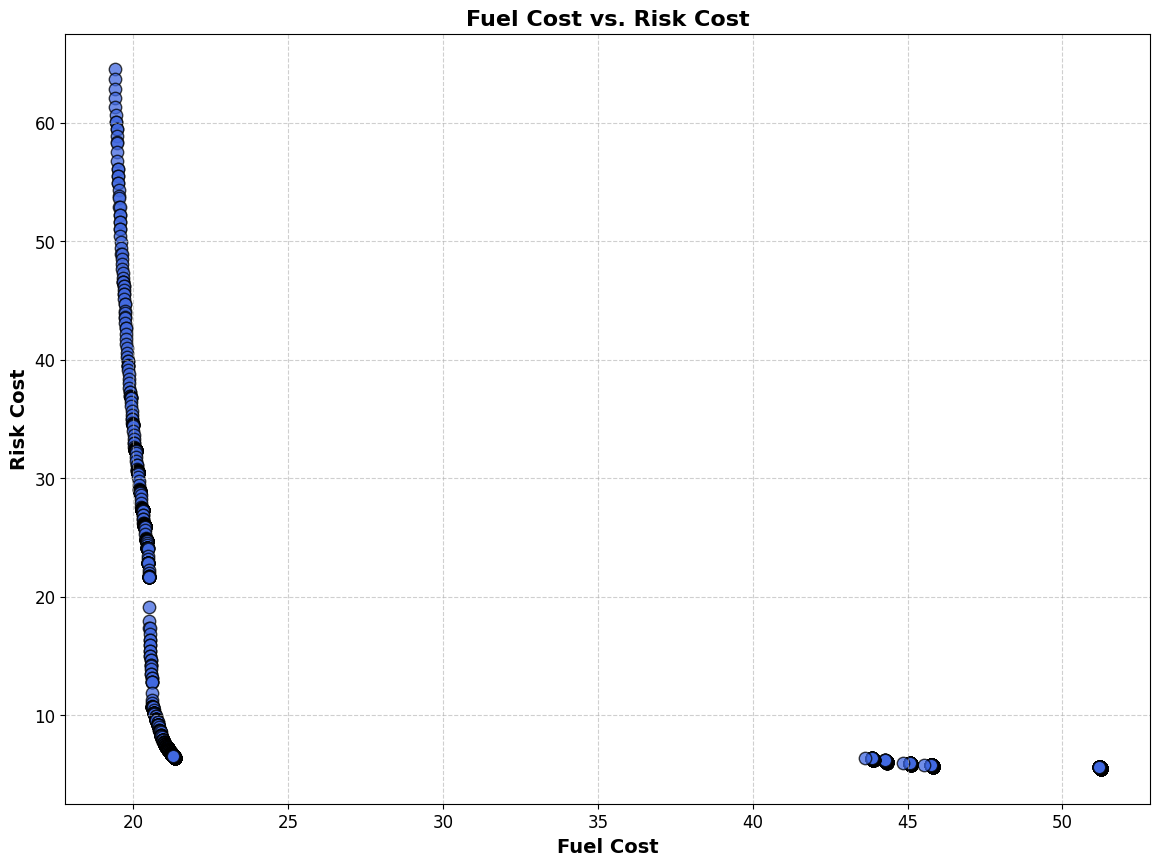

In [40]:
# =============================================================================
# Pareto Optimality Check and Plotting
# =============================================================================

# Extract cost values for the goal state
fuel_costs, risk_costs = extract_costs(sols, "g")
print("Number of solutions:", len(fuel_costs))
### Check Pareto optimality
### For solution to be Pareto optimal, it must be non-dominated, therefore, the list of dominated indices shoulb be epty
dominated_indices = check_pareto_optimality(fuel_costs, risk_costs)
print("Dominated solution indices:", dominated_indices)

# Plot the results
plot_costs(fuel_costs, risk_costs)

# Reconstruct and print all solution paths
# solution_paths = reconstruct_solution_paths(sols, "s", "g")
# print("Extracted Solution Paths:")
# for spath in solution_paths:
#     print(spath)

In [ ]:

# import heapq
# import threading
# import time
# import numpy as np

# # Combined cost-bounded A* function.
# def cost_bounded_astar(graph_object, start_state, goal_state, upper_bounds_global, direction="forward", ordering="f1f2"):
#     """
#     Unified cost-bounded A* search.
    
#     Parameters:
#       graph_object: the graph containing the nodes and edges.
#       start_state: the start node.
#       goal_state: the goal node.
#       upper_bounds_global: dict containing global upper bounds.
#       direction: "forward" or "backward". For backward, the search is run on the reversed graph,
#                  so the initial state is goal_state and the target is start_state.
#       ordering: "f1f2" or "f2f1".
#                 For "f1f2": primary cost is fuel_cost and secondary is risk_cost.
#                 For "f2f1": primary cost is risk_cost and secondary is fuel_cost.
#     """
#     # Set up search parameters based on the search direction.
#     if direction == "forward":
#         initial_state = start_state
#         target_state = goal_state
#         ub_fuel = upper_bounds_global["ub1forward"]
#         ub_risk = upper_bounds_global["ub2forward"]
#         # In a forward search we update the backward heuristic.
#         heuristic_update_direction = "backward"
#         ub_update_direction = "forward"
#     else:
#         initial_state = goal_state
#         target_state = start_state
#         ub_fuel = upper_bounds_global["ub1backward"]
#         ub_risk = upper_bounds_global["ub2backward"]
#         heuristic_update_direction = "forward"
#         ub_update_direction = "backward"
    
#     # Decide on the cost ordering.
#     if ordering == "f1f2":
#         primary_cost_key = "fuel_cost"    # primary cost (used for ordering in the heap)
#         secondary_cost_key = "risk_cost"   # secondary cost
#         # When target is reached: update global bound with the secondary cost.
#         global_bound_key = "ub2" + ("forward" if direction=="forward" else "backward")
#         # In heuristic update, we pass the primary (fuel) cost.
#         heuristic_cost_type = primary_cost_key
#         # In upper bound update, we pass the secondary (risk) cost.
#         ub_update_cost_type = secondary_cost_key
#     else:  # "f2f1"
#         primary_cost_key = "risk_cost"
#         secondary_cost_key = "fuel_cost"
#         global_bound_key = "ub1" + ("forward" if direction=="forward" else "backward")
#         heuristic_cost_type = primary_cost_key  # now primary is risk
#         ub_update_cost_type = secondary_cost_key  # and secondary is fuel

#     # Initialize open list and closed set.
#     open_list = []
#     closed = set()
#     # best_f stores the best (lowest) primary f-value for each node.
#     best_f = {node: np.inf for node in graph_object.visibility_graph.nodes()}

#     # Start with zero accumulated cost.
#     g_fuel = 0
#     g_risk = 0
#     # Use the proper heuristic estimates based on search direction.
#     heur_dir = "forward" if direction == "forward" else "backward"
#     init_heur = graph_object.visibility_graph.nodes[initial_state]["heuristic_cost"][heur_dir]
#     f_fuel = g_fuel + init_heur["fuel_cost"]
#     f_risk = g_risk + init_heur["risk_cost"]

#     # Depending on the ordering, form the tuple as:
#     # (primary f, primary g, secondary f, secondary g, state)
#     if ordering == "f1f2":
#         initial_tuple = (f_fuel, g_fuel, f_risk, g_risk, initial_state)
#         best_f[initial_state] = f_fuel
#     else:
#         initial_tuple = (f_risk, g_risk, f_fuel, g_fuel, initial_state)
#         best_f[initial_state] = f_risk

#     heapq.heappush(open_list, initial_tuple)

#     while open_list:
#         if ordering == "f1f2":
#             current_f, current_g_fuel, current_f_risk, current_g_risk, current_state = heapq.heappop(open_list)
#         else:
#             current_f, current_g_risk, current_f_fuel, current_g_fuel, current_state = heapq.heappop(open_list)

#         if current_state in closed:
#             continue

#         # Check if we have reached the target.
#         if current_state == target_state:
#             if ordering == "f1f2":
#                 update_global_upper_bound(global_bound_key, upper_bounds_global, current_g_risk)
#                 update_heuristic(graph_object, current_state, current_g_fuel, Type=heuristic_update_direction, Cost_type=heuristic_cost_type)
#             else:
#                 update_global_upper_bound(global_bound_key, upper_bounds_global, current_g_fuel)
#                 update_heuristic(graph_object, current_state, current_g_risk, Type=heuristic_update_direction, Cost_type=heuristic_cost_type)
#             closed.add(current_state)
#             print(f"Reached target {target_state}: fuel_cost = {current_g_fuel}, risk_cost = {current_g_risk}")
#             continue

#         # Feasibility check: compare the accumulated (g) costs to the global upper bounds.
#         if current_g_fuel > ub_fuel or current_g_risk > ub_risk:
#             update_heuristic(graph_object, current_state, np.inf, Type=heuristic_update_direction, Cost_type=heuristic_cost_type)
#             closed.add(current_state)
#             continue

#         # Update the heuristic and the local upper bound for this state.
#         if ordering == "f1f2":
#             update_heuristic(graph_object, current_state, current_g_fuel, Type=heuristic_update_direction, Cost_type=heuristic_cost_type)
#             update_upper_bound(graph_object, current_state, current_g_risk, Type=ub_update_direction, Cost_type=ub_update_cost_type)
#         else:
#             update_heuristic(graph_object, current_state, current_g_risk, Type=heuristic_update_direction, Cost_type=heuristic_cost_type)
#             update_upper_bound(graph_object, current_state, current_g_fuel, Type=ub_update_direction, Cost_type=ub_update_cost_type)

#         # Expand successors.
#         for successor in graph_object.visibility_graph.successors(current_state):
#             if successor in closed:
#                 continue
#             with ub_lock:
#                 edge_data = graph_object.visibility_graph.edges[current_state, successor]
#                 node_data = graph_object.visibility_graph.nodes[successor]
#             new_g_fuel = current_g_fuel + edge_data["fuel_cost"]
#             new_g_risk = current_g_risk + edge_data["risk_cost"]

#             # Compute new f-values using the proper heuristic.
#             successor_heur = node_data["heuristic_cost"][heur_dir]
#             new_f_fuel = new_g_fuel + successor_heur["fuel_cost"]
#             new_f_risk = new_g_risk + successor_heur["risk_cost"]

#             # Skip if the new g-costs exceed global bounds.
#             if new_g_fuel > ub_fuel or new_g_risk > ub_risk:
#                 update_heuristic(graph_object, current_state, np.inf, Type=heuristic_update_direction, Cost_type=heuristic_cost_type)
#                 # closed.add(successor)
#                 continue

#             if ordering == "f1f2":
#                 if new_f_fuel < best_f.get(successor, np.inf):
#                     best_f[successor] = new_f_fuel
#                     heapq.heappush(open_list, (new_f_fuel, new_g_fuel, new_f_risk, new_g_risk, successor))
#             else:
#                 if new_f_risk < best_f.get(successor, np.inf):
#                     best_f[successor] = new_f_risk
#                     heapq.heappush(open_list, (new_f_risk, new_g_risk, new_f_fuel, new_g_fuel, successor))
#         closed.add(current_state)


# # Revised parallel execution code.
# def run_parallel_cost_bounded_astar(graph_object, start_state, goal_state, upper_bounds_global, type="first"):
#     """
#     Runs two searches in parallel:
#       - The forward search.
#       - The backward search.
    
#     The 'type' parameter selects the ordering:
#       - type="first": forward search uses ordering "f1f2" and backward uses "f2f1".
#       - type="second": forward uses "f2f1" and backward uses "f1f2".
#     """
#     def forward_worker():
#         if type == "first":
#             cost_bounded_astar(graph_object, start_state, goal_state, upper_bounds_global,
#                                direction="forward", ordering="f1f2")
#         else:
#             cost_bounded_astar(graph_object, start_state, goal_state, upper_bounds_global,
#                                direction="forward", ordering="f2f1")

#     def backward_worker():
#         if type == "first":
#             cost_bounded_astar(graph_object, start_state, goal_state, upper_bounds_global,
#                                direction="backward", ordering="f2f1")
#         else:
#             cost_bounded_astar(graph_object, start_state, goal_state, upper_bounds_global,
#                                direction="backward", ordering="f1f2")

#     t1 = threading.Thread(target=forward_worker)
#     t2 = threading.Thread(target=backward_worker)
#     t1.start()
#     t2.start()
#     t1.join()
#     t2.join()


# # Example usage:
# start_time = time.time()
# run_parallel_cost_bounded_astar(graph_object, "s", "g", upper_bounds_global, type="second")
# end_time = time.time()
# print(f"The time required for second heuristic: {end_time - start_time}")

# start_time = time.time()
# run_parallel_cost_bounded_astar(graph_object, "s", "g", upper_bounds_global, type="first")
# end_time = time.time()
# print(f"The time required for first heuristic: {end_time - start_time}")